In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
import corner
import scipy.stats as st

In [5]:
Nhomework = 13

rng = np.random.default_rng()

i = rng.integers(0, Nhomework) + 1
print(i)

3


In [6]:
class MetropolisHastingsSampler:
    
    def __init__(self, lnp, seed=1492):
        
        self.lnp = lnp
        self._rng = np.random.default_rng(seed=seed)

    def __call__(self, prop, Niter, start):
        """
        prop: generate a proposal point given a starting point
        start: starting point of the sampler
        Niter: number of iterations
        """
        
        points = [start, ]
        count = 0
        
        for i in range(Niter):
            x_prop = prop(start)
            xnew, accept = self._a_step(x_prop, start)
            count += accept
            points.append(xnew)
            
            start = xnew
        
        return np.array(points), count/Niter
    
    def _a_step(self, x_prop, x_old):
        
        alpha = np.exp( self.lnp(x_prop) - self.lnp(x_old) )
        
        u = self._rng.uniform()
        
        if u<alpha:
            return x_prop, 1
        else:
            return x_old, 0

True
3.9515683983458043 1.0269332820658819
[0.14155343 0.14901089]


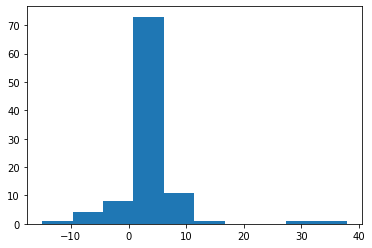

In [9]:
# Lighthouse problem

# Consider a lighthouse b away from a straight coast, at a position a. 
# It emits light rays in random uniform direction.
# we record xk, where on the coast the light ray hits.

# the emission angle is uniform between -pi/2 and pi/2

n = 100
theta = rng.uniform(low=-np.pi/2, high=np.pi/2, size=n)

a = 4
b = 1

x = b*np.tan(theta) + a

plt.hist(x)
# big outliers

# starting from P(theta|  a, b ) = C, derive the likelihood for 
# the data x and recover a and b (with errors). 
# Think of reasonable priors for a and b

def lighthouse(params, data=x):
    
    a, lnb = params
    b = np.exp(lnb)
    
    lnlikes = lnb - np.log(b**2 + (data-a)**2)
    
    return np.sum(lnlikes)

f = lambda v: -lighthouse(v)

res = minimize(f, [0, np.log(1)], tol=0.01)

print(res.success)
print( res.x[0], np.exp(res.x[1]) )

cov = res.hess_inv
s_theta = np.sqrt(np.diag(cov))
print(s_theta)

In [10]:
Niter = int(1e5)

sampler_mh = MetropolisHastingsSampler(lighthouse)

def GaussianProp(y):
    return rng.multivariate_normal(y, cov)

pnts, acpt = sampler_mh(GaussianProp, Niter, res.x)

print(acpt, pnts.shape)

0.55129 (100001, 2)


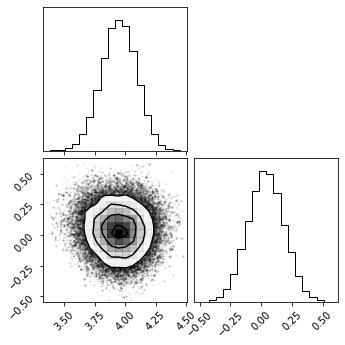

In [12]:
figure = corner.corner(pnts)

-1.076184895984271 0.07041921858487404
2.217631785170077 0.14385817625556918


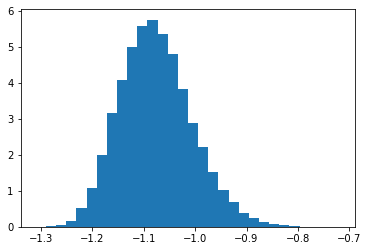

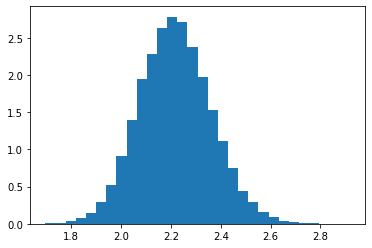

In [13]:
# staying at x0, in which direction do i have to go to reach the lighthouse
x0 = 2

phi0 = np.arctan( (x0 -  pnts[:, 0])/np.exp(pnts[:, 1]) )

plt.figure()
_ = plt.hist(phi0, density=True, bins=30)
print(np.mean(phi0), np.std(phi0))
# how far to I expect to travel from x0 to the lighthouse?

r0 = np.sqrt( (x0 -  pnts[:, 0])**2  +  np.exp(2*pnts[:, 1]) )
plt.figure()
_ = plt.hist(r0, density=True, bins=30)
print(np.mean(r0), np.std(r0))


In [11]:
# if the likelihood falls off gently
# \ln L  \propto -n \ln |delta x|
# it does not penalize outliers as strongly as a Gaussian likelihood
# \ln L_{Gauss} \propto - 1/2 |delta x|^2

# --> a good generative model for data with outlier

[4.69978949 4.2635989  7.46943644 5.55165077 5.4768774 ]
0.37144


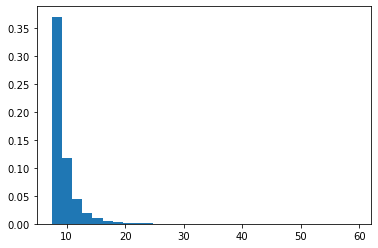

In [21]:
# German tank problem

# generative process
# l_i ~ Uniform(0, lmax)
lmax = 8
Ndata = 5

xi = rng.uniform(high=lmax, size=Ndata)

print(xi)

def lnlike_GT(lmax, data=xi):
    N = len(data)
    cut = np.amax(data)
    
    if lmax<cut:
        return -np.inf
    else: 
        return -(N+1)*np.log(lmax)
    
sampler_mh = MetropolisHastingsSampler(lnlike_GT)

def prop(y):
    return y+3*rng.normal()

pnts, acpt = sampler_mh(prop, Niter, 8)

print(acpt)
plt.figure()
_ = plt.hist(pnts, bins=30, density=True)

In [22]:
pnts

array([ 8.        ,  7.69340258,  7.69340258, ..., 18.36587653,
       18.36587653, 15.96526391])

0.37353


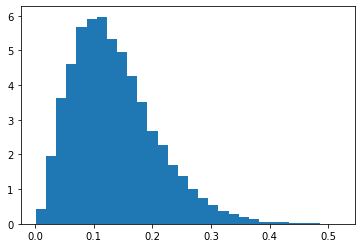

In [23]:
# modern German tank problem

# you have 200 tanks. After checking 20, you notice that only 2 are operational.
# How many tanks do you expect to work in total?
# and what is the uncertainty on that number?

nwork = 2
nsample = 20

# generative process
# nwork ~ Binomial(\pi, nsample)
# the process that generated the data is 
# drawing with unknown success chance \pi from nsample=20

# p(nwork | \pi, nsample) = comb(nwork, nsample) \pi^{nwork} (1-\pi)^(nsample-nwork)  
# <=> \ln L (pi) = nwork * \ln(\pi) + (nsample-nwork) \ln(1-\pi)

def lnlike_GT2(pi):
    if pi<0 or pi>1:
        return -np.inf
    else:
        return nwork*np.log(pi) + (nsample-nwork)*np.log(1-pi)
    
sampler_mh = MetropolisHastingsSampler(lnlike_GT2)

def prop(y):
    return y+0.2*rng.normal()

pnts, acpt = sampler_mh(prop, Niter, 0.1)

print(acpt)
plt.figure()
_ = plt.hist(pnts, bins=30, density=True)

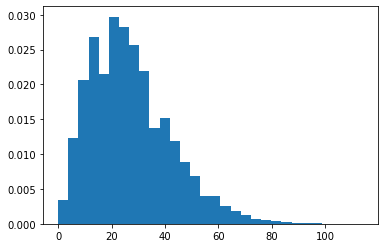

In [24]:
# Monte Carlo simulation for n number of tanks that you expect
# to work, out of your pool of Ntot=200

# while accounting for the uncertainty in pi

ntot = 200
ntarget = np.array([rng.binomial(ntot, pi) for pi in pnts])

plt.figure()
_ = plt.hist(ntarget, bins=30, density=True)

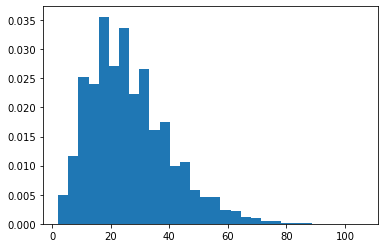

In [25]:

ntot = 200
ntarget = np.array([rng.binomial(ntot-nsample, pi)+nwork for pi in pnts])

plt.figure()
_ = plt.hist(ntarget, bins=30, density=True)

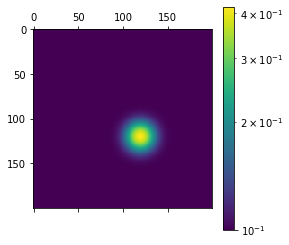

In [26]:
# fitting an X-ray source
from matplotlib.colors import LogNorm

xx = np.linspace(-5, 5, num=200)

X, Y = np.meshgrid(xx, xx)

x_center = 1
y_center = 1
sigma = 0.5
amp = 0.5
bkg = 0.1

#expected number of photons
image = bkg*np.ones(X.shape)

expo = (X-x_center)**2 + (Y-y_center)**2
image += amp*np.exp(-0.5*expo/sigma**2)/np.sqrt( (2* np.pi)**2 * sigma**4)

plt.matshow(image, norm=LogNorm())
plt.colorbar()


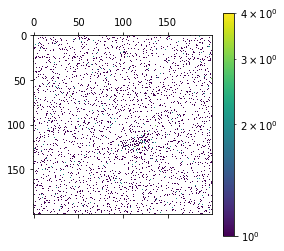

In [27]:
# the generative process in each pixel 
# in a Poisson draw from the expected number of photons
real = rng.poisson(image)

plt.matshow(real, norm=LogNorm())
plt.colorbar()

In [28]:
def source_det_like(params, data=(X, Y, real)):
    
    bkg, x, y, s, a = params
    
    X, Y, real = data
    
    model = bkg*np.ones(X.shape)
    
    expo = (X-x)**2 + (Y-y)**2
    model += a*np.exp(-0.5*expo/s**2)/np.sqrt( (2* np.pi)**2 * s**4)
    
    if s>0 and bkg>0 and a>0:
        return np.sum( real*np.log(model) - model )
    else:
        return -np.inf
    
    


In [29]:
sampler_mh = MetropolisHastingsSampler(source_det_like)

def prop(y):
    return y+0.01*rng.normal(size=5)

pnts, acpt = sampler_mh(prop, Niter, np.array([0.1, 1, 1, 0.5, 2]))

print(acpt)


0.18508


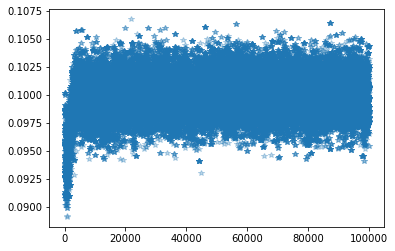

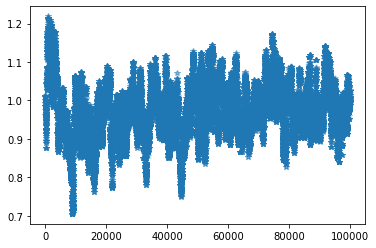

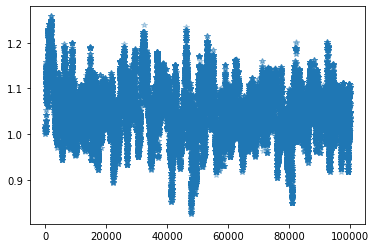

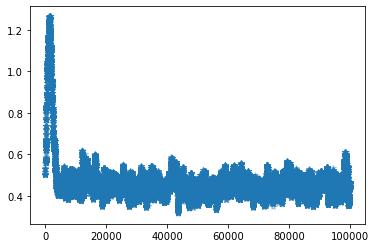

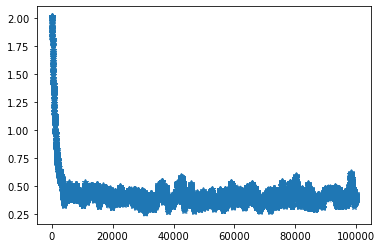

In [30]:
for i in range(pnts.shape[1]):
    plt.figure()
    plt.plot(pnts[:, i], '*', alpha=0.3)

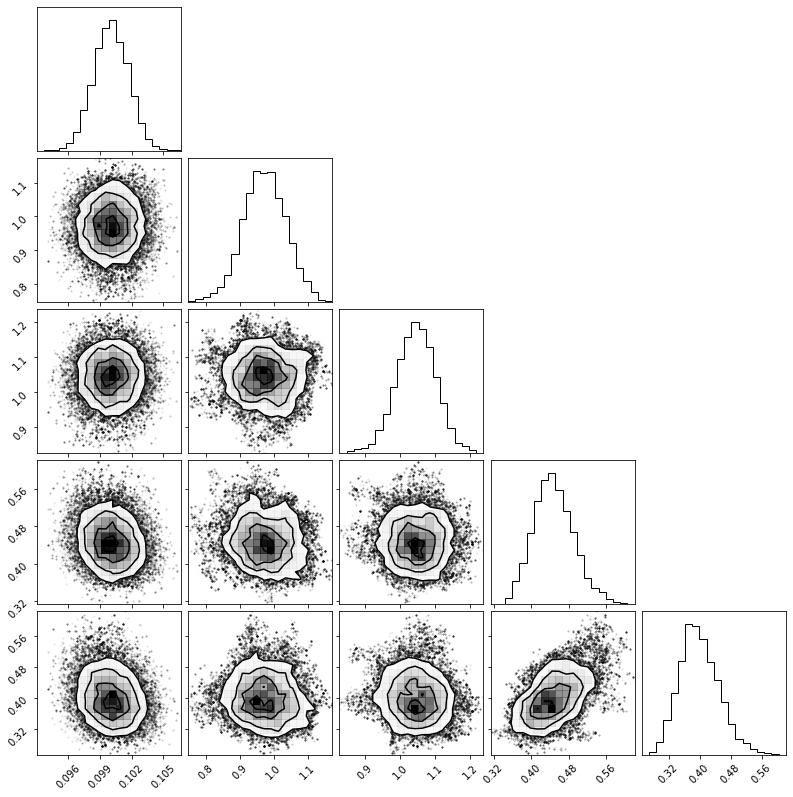

In [31]:
figure = corner.corner(pnts[10000:])

In [ ]:
# Homework: Consider N identical particles that decay. 
# Each particles decays after a time t_i
# sending you a high energy photon that you are able to detect
# Infer the half-life time of the decay process.

In [11]:
# generate the data

tau = 2
beta = tau/np.log(2) # from lecture notes \ln 2 = \lambda \tau_{1/2} 
# and \beta = 1/\lambda from https://numpy.org/doc/2.1/reference/random/generated/numpy.random.exponential.html 

# generative process
# t_i ~ Exponential(\beta) 

N_experiments = 20
ts = rng.exponential(scale=beta, size=N_experiments)

plt.figure()
_ = plt.hist(ts)

# step 1.1: derive the likelihood of t_i (pen&paper)

# L(t_i) = 

# step 1.2: derive the total log-likelihood of the data {t_i}_{i=0}^{N-1} up to constants in \tau (pen&paper)
# \ln L = \sum_i \ln L =
#       = 

# step 1.3 (extra): maximise the likelihood analytically, 
# find the maximum likelihood value \tau* (pen&paper)
# d\lnL / d\tau = 
# <=> 
# <=> \tau* = 

# find the variance of the best fit \tau* (pen&paper)
# - 1/ \sigma_\tau*^2 = d2\lnL / d2\tau |\tau* =
#                     = 
#                     = 
#                     = 
#                     = 
#                     =
# <=> \sigma_tau* = \tau*/\sqrt{N}

taustar = np.mean(ts)
sigma_tau = taustar/np.sqrt(N_experiments)

# step 2: write a function that computes the loglikelihood 
#as a function of arbitrary \ln tau

def lnlike_decay(lntau, data=ts):
    return

# step3: sample and plot the posterior of lntau



# step4: derive a posterior predictive sample for tau, 
# check its shape, report mean and standard deviation, 
# compare to the input value (do this in a nice plot )
tau_poster = 

SyntaxError: invalid syntax (2659856742.py, line 54)

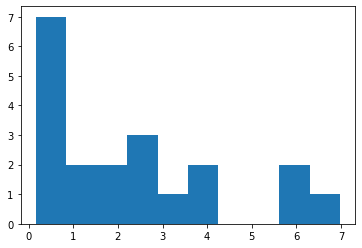

In [65]:
tau = 2
beta = tau/np.log(2) # from lecture notes \ln 2 = \lambda \tau_{1/2} 
# and \beta = 1/\lambda from https://numpy.org/doc/2.1/reference/random/generated/numpy.random.exponential.html 

# generative process
# t_i ~ Exponential(\beta) 

N_experiments = 20
ts = rng.exponential(scale=beta, size=N_experiments)

plt.figure()
_ = plt.hist(ts)

In [66]:
import numpy as np

def lnlike_decay(lntau, data=ts):
    tau = np.exp(lntau)
    sum_t = np.sum(data)
    lnL = -len(data) * lntau - (1/tau) * sum_t
    
    return lnL


0.2063


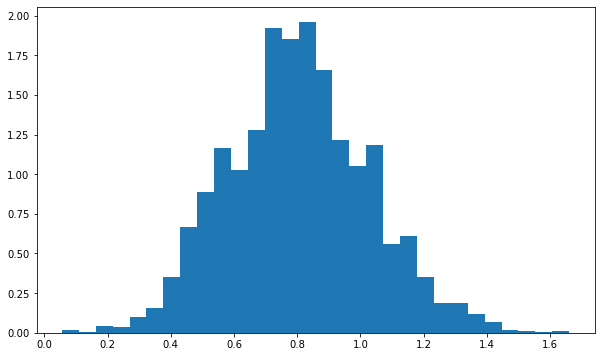

In [76]:
sampler_tau = MetropolisHastingsSampler(lnlike_decay)

def prop1(y):
    return rng.normal()

pnts, acpt = sampler_tau(prop1, Niter, 0.1)

print(acpt)
plt.figure(figsize=(10,6))
_ = plt.hist(pnts, bins=30, density=True)

Shape: (10001,)
Mean: 2.2914362020197747
Standard deviation: 0.5295858103945046


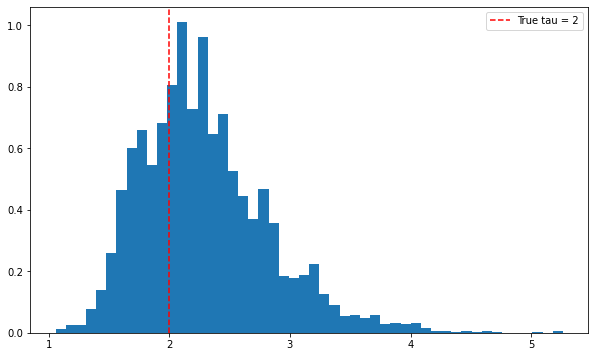

In [77]:
tau_poster = np.exp(pnts)
print(f"Shape: {tau_poster.shape}")
mean_tau = np.mean(tau_poster)
std_tau = np.std(tau_poster)


print(f"Mean: {mean_tau}")
print(f"Standard deviation: {std_tau}")



plt.figure(figsize=(10, 6))
plt.hist(tau_poster, bins=50, density=True)
plt.axvline(x=tau, color='red', linestyle='--', label=f'True tau = {tau}')
plt.legend()
plt.show()
